In [31]:
import pandas as pd
from clickhouse_driver import Client
import numpy as np

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from pyquery import PyQuery as pq
from time import sleep
import time
import re
import requests
from tqdm import tqdm_notebook

In [22]:
client = Client("localhost")

In [23]:
client.execute("SET max_memory_usage = 100000000000")

[]

In [12]:
ranks_df = pd.read_csv("clusterized_ranks", names=["address", "percentage"], sep=" ").set_index("address")

Количество адресов

In [24]:
ranks_df.shape

(999792, 1)

Равномерность распределения

(array([6.66224e+05, 1.42656e+05, 7.02870e+04, 5.79190e+04, 3.21930e+04,
        1.37110e+04, 7.96800e+03, 4.85400e+03, 3.70100e+03, 2.79000e+02]),
 array([-18.04742586, -16.99037401, -15.93332217, -14.87627033,
        -13.81921849, -12.76216665, -11.70511481, -10.64806297,
         -9.59101113,  -8.53395929,  -7.47690744]),
 <a list of 10 Patch objects>)

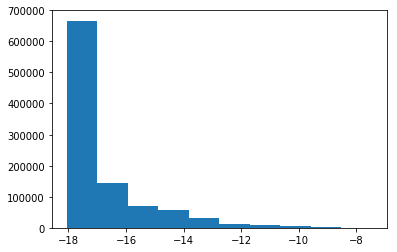

In [33]:
plt.hist(np.log(ranks_df["percentage"]))

In [213]:
ranks_df["percentage"].sort_values(ascending=False).iloc[:20000].sum()

0.8284326904442152

(-150, 20000)

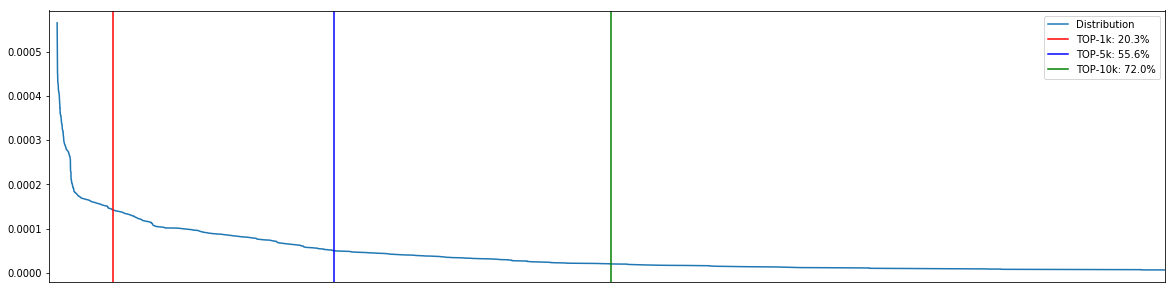

In [211]:
plt.figure(figsize=(20, 5))
plt.plot(ranks_df["percentage"].sort_values(ascending=False).iloc[:20000], label="Distribution")
plt.xticks([])
plt.axvline(1000, label="TOP-1k: {0:.1%}".format(ranks_df["percentage"].sort_values(ascending=False).iloc[:1000].sum()), color="red")
plt.axvline(5000, label="TOP-5k: {0:.1%}".format(ranks_df["percentage"].sort_values(ascending=False).iloc[:5000].sum()), color="blue")
plt.axvline(10000, label="TOP-10k: {0:.1%}".format(ranks_df["percentage"].sort_values(ascending=False).iloc[:10000].sum()), color="green")
# plt.axvline(, label="Test")
# plt.yticks([])
plt.legend()
plt.xlim(-150, 20000)

Наиболее активные адреса (убрать контракты и именованные адреса)

In [74]:
activity = client.execute("""
    SELECT from, count(*)
    FROM ethereum_internal_transaction
    WHERE 
        blockNumber > 5000000
    AND
        from not in(SELECT address FROM ethereum_contract)
    AND 
        value > 0
    GROUP BY from
""")

In [75]:
activity_df = pd.DataFrame(activity, columns=["address", "transactions"]).set_index("address")

In [76]:
ranks_with_activity_df = ranks_df.merge(activity_df, how="inner", left_index=True, right_index=True)

In [77]:
ranks_with_activity_df.sort_values("transactions", ascending=0).head(10)

,percentage,transactions
address,,
0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0.000027,642978
0xc6300135a8fcd43123bb486ff06831b5345d0971,0.000177,453387
0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,0.000011,435743
0x5dcaa1d8d8132e5bf9cf12deccfc0cecf26a780d,0.000049,202782
0xfd54078badd5653571726c3370afb127351a6f26,0.000056,172438
0x343295b49522cfc38af517c58ebb78565c42ed95,0.000050,163688
0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0.000025,153769
0x18916e1a2933cb349145a280473a5de8eb6630cb,0.000055,144264
0x5baeac0a0417a05733884852aa068b706967e790,0.000005,135305


In [78]:
ranks_with_activity_df.shape[0] * 100 / activity_df.shape[0]

5.458119976529569

In [79]:
ranks_with_activity_df["transactions"].sum() * 100 / activity_df["transactions"].sum()

9.492599230714127

In [214]:
ranks_with_activity_df["transactions"].sum()

11518277

Адреса-участники генезиса Эфира

In [230]:
ethereum_genesis = client.execute("""
    SELECT to, sum(value)
    FROM ethereum_internal_transaction
    WHERE blockNumber = 0
    AND to in(
        SELECT from 
        FROM ethereum_internal_transaction
        WHERE blockNumber > 5000000
    )
    GROUP BY to
""")

In [231]:
ethereum_genesis_df = pd.DataFrame(ethereum_genesis, columns=["address", "eth"]).set_index("address")

In [232]:
ranks_with_genesis_df = ranks_df.merge(ethereum_genesis_df, how="inner", left_index=True, right_index=True)

In [233]:
ranks_with_genesis_df.sort_values("eth", ascending=0).head(10)

,percentage,eth
address,,
0x3bf86ed8a3153ec933786a02ac090301855e576b,5.214880e-08,450000.00
0x537f9d4d31ef70839d84b0d9cdb72b9afedbdf35,7.491039e-06,70000.00
0x17125b59ac51cee029e4bd78d7f5947d1ea49bb2,2.666275e-06,22000.00
0xbfb0ea02feb61dec9e22a5070959330299c43072,1.560317e-04,20000.00
0x36d85dc3683156e63bf880a9fab7788cf8143a27,6.220137e-06,20000.00
0x562020e3ed792d2f1835fe5f55417d5111460c6a,1.126609e-06,20000.00
0xcc943be1222cd1400a2399dd1b459445cf6d54a9,1.325402e-05,12530.00
0xe6fe0afb9dcedd37b2e22c451ba6feab67348033,2.547596e-06,10000.00
0x97b91efe7350c2d57e7e406bab18f3617bcde14a,3.038474e-06,9999.98


In [234]:
ranks_with_genesis_df.shape[0]

65

In [235]:
ranks_with_genesis_df.shape[0] * 100 / ethereum_genesis_df.shape[0]

6.532663316582915

In [236]:
ranks_with_genesis_df["eth"].sum() * 100 / ethereum_genesis_df["eth"].sum()

8.766939893356918

Адреса майнеров

In [239]:
ethereum_miners = client.execute("""
    SELECT author, count(*)
    FROM ethereum_internal_transaction
    WHERE author in(
        SELECT from 
        FROM ethereum_internal_transaction
        WHERE blockNumber > 5000000
    )
    GROUP BY author
""")

In [240]:
ethereum_miners_df = pd.DataFrame(ethereum_miners, columns=["address", "blocks"]).set_index("address")

In [241]:
ranks_for_miners_df = ranks_df.merge(ethereum_miners_df, how="inner", left_index=True, right_index=True)

In [244]:
ranks_for_miners_df.shape[0] * 100 / ethereum_miners_df.shape[0]

4.306632213608958

In [243]:
ranks_for_miners_df.sort_values("blocks", ascending=False).head(10)

,percentage,blocks
address,,
0x441d463d69cb6eaa851eb6138c3efac95c86d17b,7.129562e-08,6488
0xa855c20a1351acd2690c716e2709c7dff3978d12,1.683240e-06,3051
0x9dd134d14d1e65f84b706d6f205cd5b1cd03a46b,4.643750e-07,1466
0xb6cf40aee9990c25d7d6193952af222e120b31c2,7.160081e-08,683
0x3e8702685ed7826a55acb1c6eb4a6d74638d165c,1.394298e-04,669
0x11905bd0863ba579023f662d1935e39d0c671933,1.608024e-04,430
0x4947190fcc30d3fb3a16233b259bfe6b3492339a,7.071169e-08,400
0xf78465bce3c4620fd124c67d523d2ab80a76c0d8,2.835992e-08,369
0x3b670df9fbc5866ee356b426361d57911f1da682,6.872996e-07,194


Адреса-участники других распределений

Считаем распределения с:
- Максимумом отправленных событий
- Только те сендеры, которые входят в топ-10 отправителей токена

Схема:
    - token
    - address
    - distribution_transactions
    - address_transactions

In [91]:
distribution_participants = client.execute("""
    SELECT token, to, count(*)
    FROM ethereum_token_transaction_mv
    WHERE transactionHash in(
        SELECT transactionHash
        FROM ethereum_multitransfer_transaction_mv
        WHERE sendedToken in(
            SELECT sendedToken
            FROM (
                SELECT sendedToken, count(distinct(sender)) AS senders
                FROM ethereum_multitransfer_transaction_mv
                GROUP BY sendedToken
                ORDER BY sum(events) DESC
                LIMIT 100
            )
            WHERE senders <= 5
        )
    )
    AND 
        to not in(SELECT address FROM ethereum_contract)
    GROUP BY token, to
""")

In [92]:
distribution_participants_df = pd.DataFrame(distribution_participants, columns=["token", "address", "distribution_transactions"])

In [95]:
distributions_string = ",".join(["'{}'".format(address) for address in distribution_participants_df["token"].unique()])

In [121]:
participants_activity = client.execute("""
    SELECT token, from, count(*)
    FROM ethereum_token_transaction_mv
    WHERE token in({})
    GROUP BY token, from
""".format(distributions_string))

In [122]:
participants_activity_df = pd.DataFrame(participants_activity, columns=["token", "address", "address_transactions"])

In [123]:
def check_etherscan_error(document):
  error = document("#ContentPlaceHolder1_lblAdResult + br + br + font").text()
  if "Sorry, You have reached your maximum request limit for this resource" in error:
    print("Error occured!")
    sleep(5)
    return False
  else:
    return True

def find_name(address):
  document = pq("https://etherscan.io/token/{}".format(address))
  while not check_etherscan_error(document):
    pass
  name = document("#address").text()
  return name

In [124]:
participants_activity_df = distribution_participants_df.merge(participants_activity_df, how="inner", on=["token", "address"])

In [125]:
ranks_for_active_participants_df = ranks_df.merge(participants_activity_df, how="inner", left_index=True, right_on=["address"])

In [126]:
activity_by_token_df = ranks_for_active_participants_df.groupby("token").size() * 100 / participants_activity_df.groupby("token").size()

In [127]:
activity_by_token_df = activity_by_token_df.sort_values(ascending=False).reset_index().rename(columns={0: "percentage"})

In [128]:
activity_by_token_df["name"] = [find_name(address) for address in tqdm_notebook(activity_by_token_df["token"])]

In [216]:
ranks_for_active_participants_df["address"].nunique()

18559

In [134]:
ranks_for_active_participants_df["address"].nunique() * 100 / participants_activity_df["address"].nunique()

1.705820230316522

Доля участников из списка среди активных участников эйрдропа

In [217]:
activity_by_token_df.head(10).set_index("token")

,percentage,name
token,,
0xf0df09387693690b1e00d71eabf5e98e7955cff4,66.666667,ENDO.network Promo Token
0x1a8f615f0dd39b9de8ad26db89cfa76f7c9d0274,41.463415,UTour
0xd4ae0807740df6fbaa7a258907132a2ac8d52fbc,12.845953,KEOSToken
0xa720911a58d948fc9328560aecfc51e907404fc4,11.764706,FOR Agriculture Coin
0xf2eab3a2034d3f6b63734d2e08262040e3ff7b48,10.559006,CANDY
0xd4de05944572d142fbf70f3f010891a35ac15188,9.969789,Bulleon Promo Token
0x7b2f9706cd8473b4f5b7758b0171a9933fc6c4d6,9.926082,An Etheal Promo
0x4f4d22ca77222ae3d51e308c9a8f0e564f98e77a,9.615385,Bulleon Promo Token
0xbc8deee89f1cf4b661514185aa1ab780336c4c4a,9.589041,Poker IO
